<a href="https://colab.research.google.com/github/nina499/Research_Project/blob/main/Forecasting_Meal_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Required packages and libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xgb

# Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from keras.callbacks import EarlyStopping


# Load the datasets

In [ ]:
# Load all three datasets and merge them together
fulfilment_center_raw = pd.read_csv('/content/gdrive/MyDrive/data/fulfilment_center_info.csv')
meal_info_raw = pd.read_csv('/content/gdrive/MyDrive/data/meal_info.csv')
train_data = pd.read_csv('/content/gdrive/MyDrive/data/train.csv')

#Merge the train raw  with meal info raw as train_merge
train_merge = pd.merge(train_data, meal_info_raw, on = 'meal_id', how = 'left')
#Merge train_merge with fulfulment center raw as train_data
train_data = pd.merge(train_merge, fulfilment_center_raw, on ='center_id', how = 'left')

# Data Exploration

In [ ]:
# Check the top 5 rows (samples) from the merged dataset
train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [ ]:
# Check basic statistics
train_data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


Text(0, 0.5, 'num of meal orders')

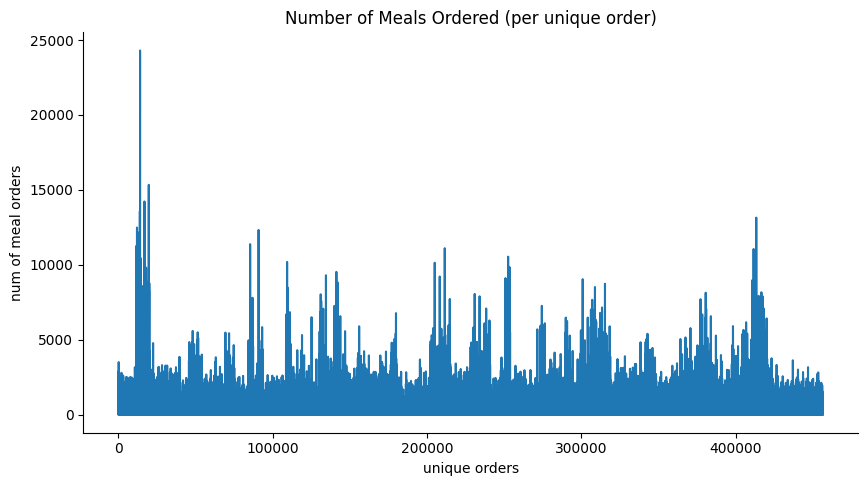

In [ ]:
# Visualize all target values over the span of 145 weeks
xy = train_data[['week', 'num_orders']]
from matplotlib import pyplot as plt
xy['num_orders'].plot(kind='line', figsize=(10, 5.2), title='Number of Meals Ordered (per unique order)')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('unique orders')
plt.ylabel('num of meal orders')

# Feature Engineering

In [ ]:
# DROP id
train_data.drop(['id'], axis=1, inplace=True)

# Convert features with categorical variables into indicator variables
train_data = pd.get_dummies(train_data, columns=["category"], prefix="category", drop_first=True)
train_data = pd.get_dummies(train_data, columns=["cuisine"], prefix="cuisine", drop_first=True)
train_data = pd.get_dummies(train_data, columns=["center_type"], prefix="center_type", drop_first=True)
train_data = pd.get_dummies(train_data, columns=['city_code'], prefix='city_code', drop_first=True)
train_data = pd.get_dummies(train_data, columns=['region_code'], prefix='region_code', drop_first=True)
train_data = pd.get_dummies(train_data, columns=['op_area'], prefix='op_area', drop_first=True)
train_data = pd.get_dummies(train_data, columns=['center_id'], prefix='center_id', drop_first=True)
train_data = pd.get_dummies(train_data, columns=['meal_id'], prefix='meal_id', drop_first=True)

# Remove "num_orders" column and assigns it to col
col = train_data.pop("num_orders")
# Insert "num_orders" column at the end of the dataframe because this is our dependent variable
train_data.insert(len(train_data.columns), "num_orders", col)

Check for any missing or invaid values

In [ ]:
# Check for null values in the dataframe, 0 if none
train_data.isnull().sum().sum()

0

In [ ]:
# Check the now merged and engineered dataset
train_data.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,...,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,num_orders
0,1,136.83,152.29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,177
1,1,136.83,135.83,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,270
2,1,134.86,135.86,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,189
3,1,339.50,437.53,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54
4,1,243.50,242.50,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,40


# Random Forest Regressor

Train and Test Split

In [ ]:
#Copy the data and keep the original as is
train_data_rf = train_data.copy()

# Drop the last column (the independent variables)
X = train_data_rf.drop('num_orders', axis = 1)

# Assign the last column to y (the dependent variable to be predicted)
y = train_data_rf['num_orders']

# Split the data and define the split parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

Build, Train, and Test the random forest model

In [ ]:
# Create the Random Forest model object and define the model hyperparameters
rf_model = RandomForestRegressor(n_estimators=200, criterion = 'squared_error',
                                 max_depth = None, min_samples_leaf =3,
                                 bootstrap = True, oob_score = True)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict train and test accuracy
y_train_pred = rf_model.predict (X_train)
y_test_pred = rf_model.predict(X_test)

# Accuracy metrics
rf_mae = mean_absolute_error(y_test, y_test_pred)
rf_mse = mean_squared_error(y_test, y_test_pred)
rf_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f'MAE: %.2f' % rf_mae)
print(f'MSE: %.2f' % rf_mse)
print(f'RMSE: %.2f' % rf_rmse)

# Calculate and print the R-squared scores for train, test, and out of bag
train_r2 = r2_score (y_train, y_train_pred)
test_r2 = r2_score (y_test, y_test_pred)
print (f'Training R-Squared Value: %.2f' % train_r2)
print (f'Testing R-Squared Value: %.2f' % test_r2)
print(f'OOB score: %.2f' % rf_model.oob_score_)

MAE: 68.31
MSE: 23043.31
RMSE: 151.80
Training R-Squared Value: 0.93
Testing R-Squared Value: 0.85
OOB score: 0.85


Feature Importance

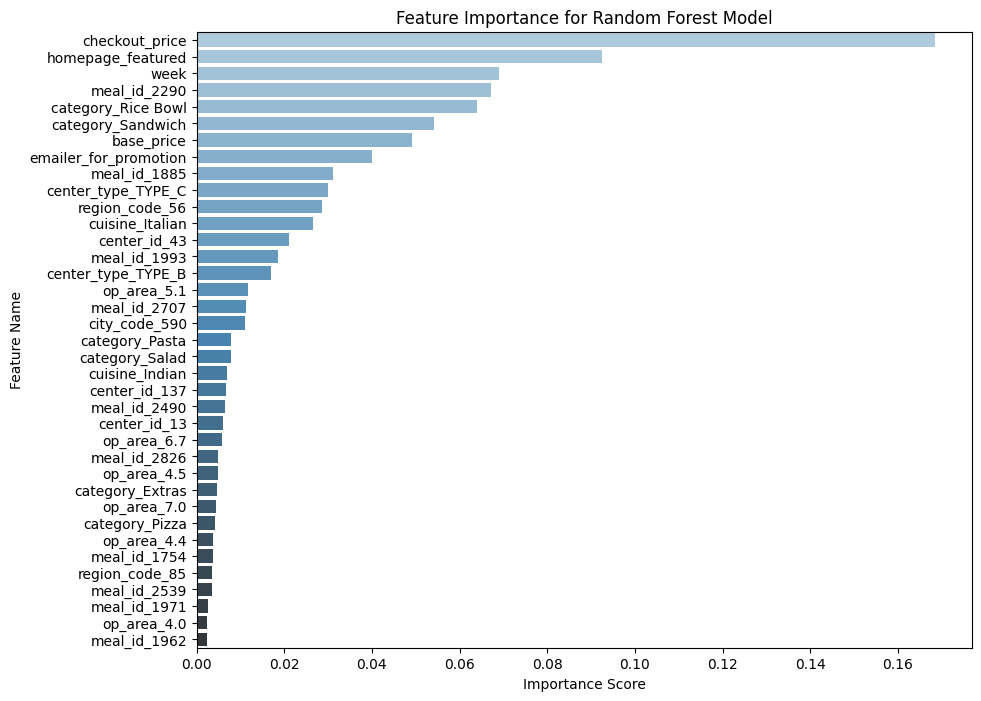

In [ ]:
# Get the feature importance scores fo the first 37 features
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(37)

plt.figure (figsize= (10, 8))
sns.barplot (x=feat_importances, y=feat_importances.index, palette="Blues_d")
plt.title ("Feature Importance for Random Forest Model")
plt.xlabel ("Importance Score")
plt.ylabel ("Feature Name")
plt.show ()

In [ ]:
# Check the values of each feature in importance
print(" Important scores for the top 37 features")
feat_importances

 Important scores for the top 37 features


checkout_price           0.168436
homepage_featured        0.092584
week                     0.069006
meal_id_2290             0.067127
category_Rice Bowl       0.063936
category_Sandwich        0.054166
base_price               0.049249
emailer_for_promotion    0.039966
meal_id_1885             0.031104
center_type_TYPE_C       0.029972
region_code_56           0.028625
cuisine_Italian          0.026503
center_id_43             0.021188
meal_id_1993             0.018570
center_type_TYPE_B       0.017073
op_area_5.1              0.011730
meal_id_2707             0.011170
city_code_590            0.011145
category_Pasta           0.007807
category_Salad           0.007740
cuisine_Indian           0.007025
center_id_137            0.006622
meal_id_2490             0.006450
center_id_13             0.005980
op_area_6.7              0.005740
meal_id_2826             0.004982
op_area_4.5              0.004831
category_Extras          0.004595
op_area_7.0              0.004310
category_Pizza

# XGBoost Regressor

Train Test Split

In [ ]:
#Copy the data and keep the original as is
train_data_xg = train_data.copy()

# Drop the last column (the independent variables)
X = train_data_xg.drop('num_orders', axis = 1)

# Assign the last column to y (the dependent variable to be predicted)
y = train_data_xg['num_orders']

# Split the data and define the split parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

Build, Train, and Test the XGBoost model

In [ ]:
# Create the XGBoost object and define the model hyperparameters
xg_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.3,
                              max_depth=8, subsample = 0.8, colsample_bytree = 0.8)

# Fit the data with an evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


# Predict
y_train_pred = xg_model.predict(X_train)
y_test_pred = xg_model.predict(X_test)

# Accuracy metrics
xg_mae = mean_absolute_error(y_test, y_test_pred)
xg_mse = mean_squared_error(y_test, y_test_pred)
xg_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f'MAE: %.2f' % xg_mae)
print(f'MSE: %.2f' % xg_mse)
print(f'RMSE: %.2f' % xg_rmse)

# Evaluate accuracy
train_acc = r2_score(y_train, y_train_pred)
test_acc = r2_score(y_test, y_test_pred)
print(f"Training R-Squared Value: %.2f" % train_acc)
print(f"Testing R-Squared Value: %.2f" % test_acc)



MAE: 67.10
MSE: 17665.96
RMSE: 132.91
Training R-Squared Value: 0.94
Testing R-Squared Value: 0.88


Plot the RMSE Accuracy Evaluation

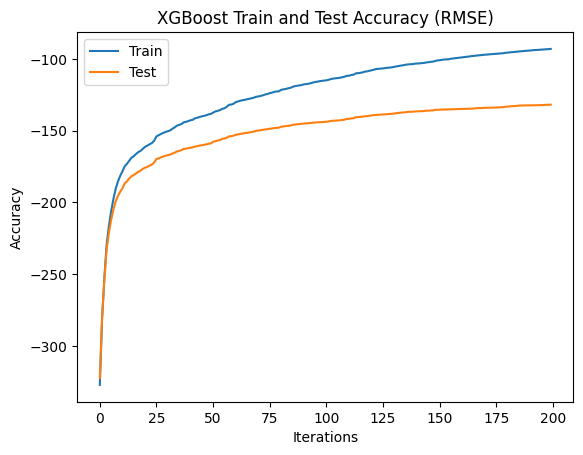

In [ ]:
#NEW: Get accuracy values
results = xg_model.evals_result()
train_acc = [1 - x for x in results['validation_0']['rmse']]
test_acc = [1 - x for x in results['validation_1']['rmse']]

#NEW Plot accuracy
epochs = len(train_acc)
x_axis = range(0, epochs)
plt.plot(x_axis, train_acc, label='Train')
plt.plot(x_axis, test_acc, label='Test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('XGBoost Train and Test Accuracy (RMSE)')
plt.show()

Feature Importance

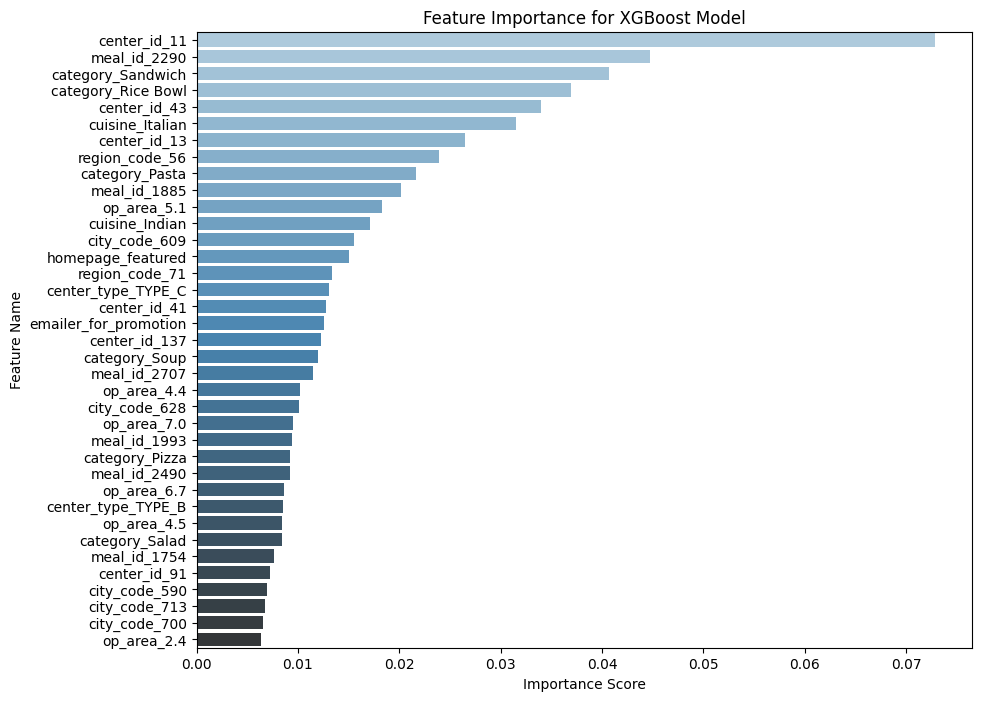

In [ ]:
#Getting the feature importance scores for the top 37 features
feat_importances = pd.Series(xg_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(37)

plt.figure (figsize= (10, 8))
sns.barplot (x=feat_importances, y=feat_importances.index, palette="Blues_d")
plt.title ("Feature Importance for XGBoost Model")
plt.xlabel ("Importance Score")
plt.ylabel ("Feature Name")
plt.show ()

In [ ]:
# Check the values of each feature in importance
print(" Important scores for the top 37 features")
feat_importances

 Important scores for the top 37 features


center_id_11             0.072837
meal_id_2290             0.044771
category_Sandwich        0.040707
category_Rice Bowl       0.036906
center_id_43             0.033933
cuisine_Italian          0.031524
center_id_13             0.026488
region_code_56           0.023886
category_Pasta           0.021666
meal_id_1885             0.020175
op_area_5.1              0.018250
cuisine_Indian           0.017112
city_code_609            0.015514
homepage_featured        0.015057
region_code_71           0.013369
center_type_TYPE_C       0.013020
center_id_41             0.012794
emailer_for_promotion    0.012563
center_id_137            0.012278
category_Soup            0.011936
meal_id_2707             0.011518
op_area_4.4              0.010196
city_code_628            0.010094
op_area_7.0              0.009529
meal_id_1993             0.009396
category_Pizza           0.009169
meal_id_2490             0.009168
op_area_6.7              0.008580
center_type_TYPE_B       0.008566
op_area_4.5   

# MLP Regressor

Train Test Split

In [ ]:
# Copy the data and keep the original as is
train_data_mlp = train_data.copy()

# Encode additional column required for LP model
train_data_mlp = pd.get_dummies(train_data_mlp, columns=['week'], prefix='week', drop_first=True)

#remove "num_orders" column and assigns it to col
col = train_data_mlp.pop("num_orders")

#insert "num_orders" column at the end of the dataframe because this is our dependent variable
train_data_mlp.insert(len(train_data_mlp.columns), "num_orders", col)

# Drop the last column (the independent variables)
X = train_data_mlp.drop('num_orders', axis = 1)

# Assign the last column to y (the dependent variable to be predicted)
y = train_data_mlp['num_orders']

# Split the data and define the split parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

Transform Numerical Features

In [ ]:
# Transform the numerical features using MinMaxScaler
numerical_cols = ['checkout_price', 'base_price']

preprocessor = ColumnTransformer(transformers=
 [('num', MinMaxScaler(), numerical_cols)],remainder='passthrough') # This leaves binary/indicator variables untouched

# Fit and transform the data.
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)

In [ ]:
# Build the MLP model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim = X_train_transformed.shape[1],
                activation = 'relu'))
# Regularization technique to prevent overfitting
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation = 'linear'))

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mae'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               48512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56833 (222.00 KB)
Trainable params: 56833 (222.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(X_train_transformed, y_train, epochs = 50, validation_split
                    = 0.2, batch_size = 32, callbacks=[early_stopping])

Epoch 1/50
9131/9131 [==============================] - 39s 4ms/step - loss: 57365.9297 - mae: 110.0042 - val_loss: 34773.6758 - val_mae: 89.8508
Epoch 2/50
9131/9131 [==============================] - 43s 5ms/step - loss: 35852.4336 - mae: 89.3625 - val_loss: 27385.9082 - val_mae: 81.3856
Epoch 3/50
9131/9131 [==============================] - 36s 4ms/step - loss: 29696.8340 - mae: 83.8763 - val_loss: 24798.4609 - val_mae: 78.6843
Epoch 4/50
9131/9131 [==============================] - 42s 5ms/step - loss: 26575.8516 - mae: 80.9594 - val_loss: 22245.9434 - val_mae: 76.4372
Epoch 5/50
9131/9131 [==============================] - 38s 4ms/step - loss: 24674.5469 - mae: 79.1384 - val_loss: 20567.1113 - val_mae: 74.1494
Epoch 6/50
9131/9131 [==============================] - 38s 4ms/step - loss: 22967.3164 - mae: 77.8959 - val_loss: 19740.4980 - val_mae: 72.6943
Epoch 7/50
9131/9131 [==============================] - 38s 4ms/step - loss: 21684.0352 - mae: 76.5899 - val_loss: 18844.3457 - v

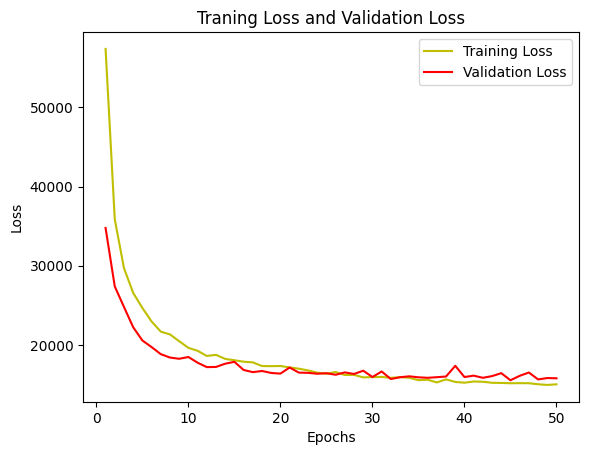

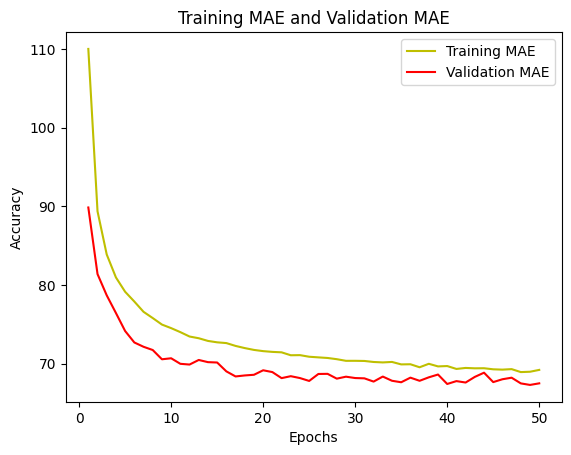

In [ ]:
# Graph the loss history to check accuracy and possible overfitting

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1) #
plt.plot(epochs, loss, 'y', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Traning Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['mae']
val_accuracy = history.history['val_mae']
plt.plot(epochs, accuracy, 'y', label = 'Training MAE')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation MAE')
plt.title('Training MAE and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict labels for train and test sets
y_train_pred = model.predict(X_train_transformed)
y_test_pred = model.predict(X_test_transformed)

#Accuracy metrics
ann_mae = mean_absolute_error(y_test, y_test_pred)
ann_mse = mean_squared_error(y_test, y_test_pred)
ann_score = r2_score(y_test, y_test_pred)
ann_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f'MAE: %.2f'% ann_mae)
print(f'MSE: %.2f'% ann_mse)
print(f'RMSE: %.2f'% ann_rmse)

# Evaluate accuracy
train_acc = r2_score(y_train, y_train_pred)
test_acc = r2_score(y_test, y_test_pred)
print("Training R-Squared Value: %.2f" % train_acc)
print("Testing R-Squared Value: %.2f" % test_acc)

2854/2854 [==============================] - 6s 2ms/step
MAE: 70.63
MSE: 17180.83
RMSE: 131.08
Training R-Squared Value: 0.93
Testing R-Squared Value: 0.89


# One-dimensional CNN with Regression

In [ ]:
#Copy the data and keep the original as is
train_data_cnn = train_data.copy()

# Encode additional column required for LP model
train_data_cnn = pd.get_dummies(train_data_cnn, columns=['week'], prefix='week', drop_first=True)

#remove "num_orders" column and assigns it to col
col = train_data_cnn.pop("num_orders")

#insert "num_orders" column at the end of the dataframe because this is our dependent variable
train_data_cnn.insert(len(train_data_cnn.columns), "num_orders", col)

# Drop the last column (the independent variables)
X = train_data_cnn.drop('num_orders', axis = 1)

# Assign the last column to y (the dependent variable to be predicted)
y = train_data_cnn['num_orders']

# Split the data and define the split parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

Scale, transform, and Reshape to fit convolutional shape

In [ ]:
numerical_cols = ['checkout_price', 'base_price']

#Scale
preprocessor = ColumnTransformer(transformers=
 [('num', MinMaxScaler(feature_range=(0,1)), numerical_cols)],remainder='passthrough')

#Transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)

#Reshape
sample_size = X_train_transformed.shape[0]
time_steps = X_train_transformed.shape[1]
input_dimension = 1

#Reshape X_train
train_data_transformed_reshaped = X_train_transformed.reshape(sample_size, time_steps, input_dimension)
#Reshape X_test
test_data_transformed_reshaped = X_test_transformed.reshape(X_test_transformed.shape[0], X_test_transformed.shape[1], 1)

#Check the new shapes
print('New X_train shape: ', train_data_transformed_reshaped.shape)
print('Sample shape: ', train_data_transformed_reshaped[0].shape)
print()
print('New X_test shape: ', test_data_transformed_reshaped.shape)
print('Sample shape: ', train_data_transformed_reshaped[0].shape)

New X_train shape:  (365238, 378, 1)
Sample shape:  (378, 1)

New X_test shape:  (91310, 378, 1)
Sample shape:  (378, 1)


Build the CNN model

In [ ]:
#Reshape
n_timesteps = train_data_transformed_reshaped.shape[1]
n_features = train_data_transformed_reshaped.shape[2]

#Initiate the CNN model
model = Sequential()

#Input layer with 128 filters and kernel size of 10
model.add(Conv1D(filters=128, kernel_size=3, activation='relu',
                 input_shape=(n_timesteps,n_features)))

#Regularization technique to prevent overfitting
model.add(Dropout(0.2))

#Hidden layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#Reduces the spatial dimensions
model.add(MaxPooling1D(pool_size=2))

#Add a flatten layer to convert the 3D output to 1D
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))

#output dense layer with one neuron
model.add(Dense(n_features, activation='linear'))

In [ ]:
#Compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = 'mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 376, 128)          512       
                                                                 
 dropout_4 (Dropout)         (None, 376, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 374, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 187, 64)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 11968)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                383008    
                                                      

In [ ]:
#Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(train_data_transformed_reshaped, y_train, epochs = 50,
                    validation_split = 0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
9131/9131 [==============================] - 55s 6ms/step - loss: 53452.1875 - mae: 116.6303 - val_loss: 37291.2305 - val_mae: 105.2038
Epoch 2/50
9131/9131 [==============================] - 47s 5ms/step - loss: 37262.8711 - mae: 100.6068 - val_loss: 33010.9922 - val_mae: 99.9734
Epoch 3/50
9131/9131 [==============================] - 46s 5ms/step - loss: 34481.1836 - mae: 97.5102 - val_loss: 30857.2598 - val_mae: 95.1305
Epoch 4/50
9131/9131 [==============================] - 45s 5ms/step - loss: 31684.9980 - mae: 95.2756 - val_loss: 31147.6777 - val_mae: 93.0785
Epoch 5/50
9131/9131 [==============================] - 45s 5ms/step - loss: 30605.1309 - mae: 94.2541 - val_loss: 27600.1797 - val_mae: 92.2231
Epoch 6/50
9131/9131 [==============================] - 46s 5ms/step - loss: 28854.2109 - mae: 93.1251 - val_loss: 41126.6680 - val_mae: 100.7996
Epoch 7/50
9131/9131 [==============================] - 45s 5ms/step - loss: 28191.8438 - mae: 92.1563 - val_loss: 26838.3027 

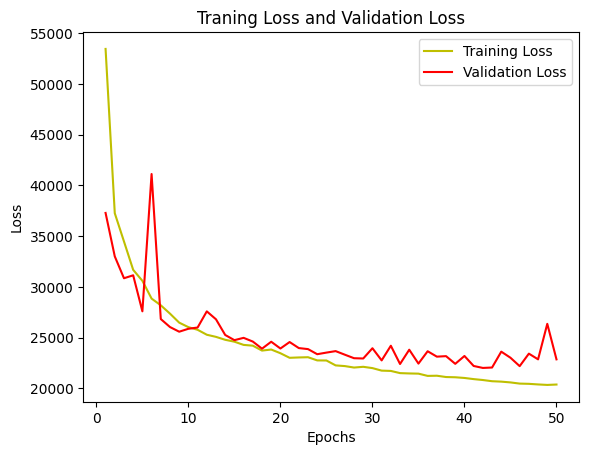

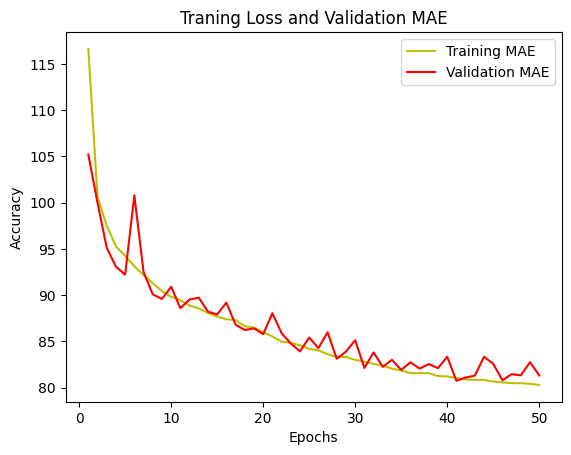

In [ ]:
#Graph

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1) #
plt.plot(epochs, loss, 'y', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Traning Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['mae']
val_accuracy = history.history['val_mae']

plt.plot(epochs, accuracy, 'y', label = 'Training MAE')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation MAE')
plt.title('Traning Loss and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict labels for train and test sets
y_train_pred = model.predict(train_data_transformed_reshaped)
y_test_pred = model.predict(test_data_transformed_reshaped)

#Accuracy evaluation
cnn_mae = mean_absolute_error(y_test, y_test_pred)
cnn_mse = mean_squared_error(y_test, y_test_pred)
cnn_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f'MAE: %.2f' % cnn_mae)
print(f'MSE: %.2f' % cnn_mse)
print(f'RMSE: %.2f' % cnn_rmse)


# Evaluate train and test R-Score
train_acc = r2_score(y_train, y_train_pred)
test_acc = r2_score(y_test, y_test_pred)
print("Training R-Squared Value: %.2f" % train_acc)
print("Testing R-Squared Value: %.2f" % test_acc)

2854/2854 [==============================] - 5s 2ms/step
MAE: 81.91
MSE: 22264.35
RMSE: 149.21
Training R-Squared Value: 0.87
Testing R-Squared Value: 0.85
